In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy.ma as ma

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/archie/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# read in data 

# import data

maxlon = 171
minlon = 130

Tok1 = pd.read_csv('../data/Tokyo1_chl.csv', sep=',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)-1000
Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]


Tok2 = pd.read_csv('../data/Tokyo3_chl.csv', sep=',')
Tok2['density'] = sw.rho(Tok2['S'].values,Tok2['T'].values,0)-1000

Tok3 = pd.read_csv('../data/Tokyo3_chl.csv', sep=',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)-1000
Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tok3f = pd.read_csv(r'../data/filtered_O2Ar/Tokyo3_filt_vOct17.csv',sep=',')
Tok3f['density'] = sw.rho(Tok3f['S'].values,Tok3f['T'].values,0)-1000
Tok3f = Tok3f[(Tok3f['Lon']>minlon) & (Tok3f['Lon']<maxlon)]

Tian = pd.read_csv('../data/Tian_chl.csv',sep=',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)-1000
Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Unnamed: 0', u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo',
       u'TrueO2Ar', u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn',
       u'Air-sea flux', u'density', u'dx', u'x', u'chl'],
      dtype='object')


In [3]:
data = pd.concat([Tok1,  Tok3, Tian], ignore_index = True)

subset = data 

# bin the nitrate data into sigma vs latitude bins

dy = 0.5
dx = 1.

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 45., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binned = np.empty([len(xbin), len(ybin)])
binnedstd = np.empty([len(xbin), len(ybin)])
fvar = 'chl'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)

        if nn > 0:
            binned[i,j] = np.nanmean(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
            binnedstd[i,j] = np.nanstd(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
        else:
            binned[i,j] = np.nan
            binnedstd[i,j] = np.nan


In [4]:
data = pd.concat([Tok1,  Tok3f, Tian], ignore_index = True)

subset = data 

# bin the nitrate data into sigma vs latitude bins

dy = 0.5
dx = 1.

ybin = np.arange(21., 27., dy)
xbin = np.arange(30., 45., dx)

xgrid, ygrid = np.meshgrid(xbin, ybin, sparse=False, indexing='ij')

binnedncp = np.empty([len(xbin), len(ybin)])
binnedncpstd = np.empty([len(xbin), len(ybin)])
fvar = 'Air-sea flux'

for i in range(len(xbin)):
    lat = xbin[i]
    for j in range(len(ybin)):
        sig = ybin[j]

        nn = len(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)

        if nn > 0:
            binnedncp[i,j] = np.nanmean(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
            binnedncpstd[i,j] = np.nanstd(subset.loc[((subset['Lat']>lat-dx/2) & (subset['Lat']<lat +dx/2) & (subset['density']>sig -dy/2)
                                        & (subset['density']<sig +dy/2)), fvar].values)
        else:
            binnedncp[i,j] = np.nan
            binnedncpstd[i,j] = np.nan


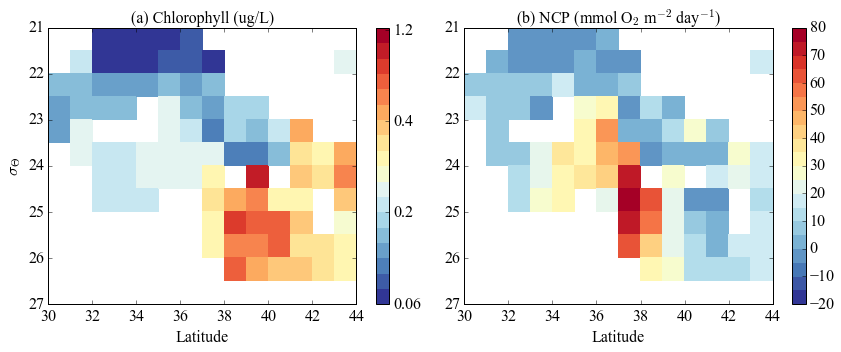

In [6]:
fig1 , (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5), dpi = 300)

palette = plt.get_cmap('RdYlBu_r',18)
palette2 = plt.get_cmap('RdYlBu_r',20)


binned = ma.masked_where(np.isnan(binned), binned)
binnedstd = ma.masked_where(np.isnan(binnedstd), binnedstd)

palette.set_bad('grey')

chl = ax1.pcolor(xgrid, ygrid, np.log10(binned), vmin = -1.2, vmax = 0.01, lw=0, cmap = palette)

cb = fig1.colorbar(chl, ax=ax1, ticks = np.arange(-1.2, 0.01, 0.4))
cb.ax.set_yticklabels(['0.06','0.2','0.4','1.2'])
ax1.set_title('(a) Chlorophyll (ug/L)', fontsize = 16)

ax1.invert_yaxis()
# ax1.set_axes([30,45, 26.5, 22.0])


binnedncp = ma.masked_where(np.isnan(binnedncp), binnedncp)
ncp = ax2.pcolor(xgrid, ygrid, binnedncp, vmin = -20, vmax = 80, lw=0, cmap = palette2)

cb2 = fig1.colorbar(ncp, ax=ax2, ticks = np.arange(-20, 81, 10))
ax2.set_title('(b) NCP (mmol O$_2$ m$^{-2}$ day$^{-1}$)', fontsize = 16)


ax1.set_ylabel(r'$\sigma_{\Theta}$', fontsize = 16)
ax1.set_xlabel('Latitude', fontsize = 16)
ax2.set_xlabel('Latitude', fontsize = 16)

ax2.invert_yaxis()

ax1.xaxis.set_tick_params(labelsize=16)
ax2.xaxis.set_tick_params(labelsize=16)

ax1.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)


cb.ax.tick_params(labelsize=16)
cb2.ax.tick_params(labelsize=16)

plt.show()

fig1.savefig('../manuscript/Figure7.png', bbox_inches='tight', dpi=600)